# Group Project - AI for Security

**Members:**
- Andrea Ferrazzano - andrea1.ferrazzano@mail.polimi.it - 10703279
- Marco Gorini - marco2.gorini@mail.polimi.it - 10710545
- Leonardo Saveri - leonardo.saveri@mail.polimi.it - 10745545
- Claudia Pierpaoli - claudia.pierpaoli@mail.polimi.it - 11016822

## Imports

In [21]:
!pip3 install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
     |████████████████████████████████| 235 kB 1.9 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from joblib import dump, load
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
import time
from sklearn.metrics import (
    accuracy_score, 
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    roc_auc_score,
    RocCurveDisplay,
    auc
)
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate

from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

# Preparing the data

In [2]:
df_train = pd.read_csv("data/df_train.csv")
df_test = pd.read_csv("data/df_test.csv")

print(df_train.shape)
df_test.shape

(55749, 32)


(16000, 32)

In [3]:
df_train.columns

Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'fin_flag_number', 'syn_flag_number', 'rst_flag_number',
       'psh_flag_number', 'ack_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'SSH', 'TCP',
       'UDP', 'ICMP', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT',
       'Covariance', 'Variance', 'label', 'category_label'],
      dtype='object')

In [4]:
X_train = df_train.drop(columns=["label", "category_label"])
X_test = df_test.drop(columns=["label", "category_label"])

y_train = df_train["category_label"]
y_test = df_test["category_label"]

Let's divide the dataset into train and test sets. In this case, we are using 20% of the dataset as test.

Now we are scaling values in the train and the test set (everything in this case, because there are only numerical features) to have better performances and predictions.

In [5]:
standard_scaler = StandardScaler().fit(X_train)

X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

Let's save the standars scaler also for the future

In [6]:
#dump(standard_scaler, "scalers/standard_scaler.bin", compress=True)

In [7]:
X_train

array([[-0.36801019, -0.35346166,  0.46054157, ..., -0.01018213,
        -0.35051081, -1.27017796],
       [-0.36888444, -0.38354661, -0.52506693, ..., -0.01058209,
        -0.35051081, -1.27017796],
       [-0.36888444, -0.38354661, -0.52506693, ..., -0.00643102,
        -0.35051081, -1.27017796],
       ...,
       [ 0.36874052, -0.37683062, -0.33690531, ...,  1.26147349,
        -0.34579192,  0.99974844],
       [-0.11088783, -0.32960377, -0.52506693, ...,  1.2614745 ,
         1.57512056,  0.99974844],
       [ 0.73144974, -0.33881354, -0.22938438, ..., -1.27568763,
        -0.34866664,  0.7727558 ]])

In [8]:
X_test

array([[-0.3594684 ,  3.34878602, -0.52506693, ...,  1.26151154,
         3.37066307,  0.99974844],
       [-0.33873717, -0.38126271,  0.46054157, ..., -1.27568763,
        -0.3451429 ,  0.7727558 ],
       [-0.36784072, -0.38318251, -0.52506693, ..., -1.27568763,
        -0.35007724,  0.7727558 ],
       ...,
       [ 0.53284477, -0.34475238, -0.47130647, ...,  1.26163369,
        -0.34559026,  0.99974844],
       [ 0.09184591, -0.32815799,  0.26341987, ..., -1.27568763,
        -0.34286041,  0.7727558 ],
       [-0.36888444, -0.38354661, -0.52506693, ..., -0.00644665,
        -0.35051081, -1.27017796]])

In [9]:
label2id = {'BenignTraffic': 0, 'Mirai': 1, 'DDoS': 1, 'Spoofing': 1, 'Web': 1, 'Recon': 1, 'BruteForce': 1, 'DoS': 1}
id2label = {0: 'BenignTraffic', 1: 'MaliciousTraffic'}

y_train = [label2id[label] for label in y_train]
y_test = [label2id[label] for label in y_test]


In [10]:
Counter(y_train)

Counter({1: 48731, 0: 7018})

because the classes are very much unbalanced, we'll perform some undersampling


(14036, 30) (14036,)
0    7018
1    7018
dtype: int64


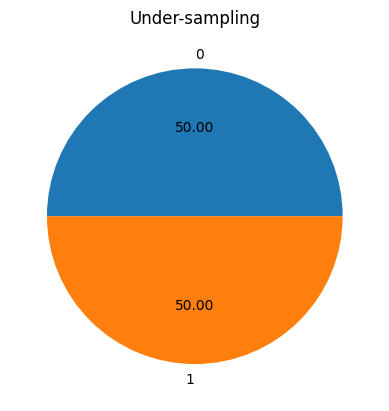

In [11]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X_res, y_res = rus.fit_resample(X_train, pd.Series( (v for v in y_train) ))
print(X_res.shape, y_res.shape)
print(y_res.value_counts())

ax = y_res.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")

Now our data is balanced. We undersampled our malicious values to be the same amount benign values. 

# Let's prepare also the final test we will use with each best classifier

In [12]:
df_test_final = pd.read_csv("data/final_test_data.csv")
df_test_final = df_test_final[df_train.columns]

X_test_final = df_test_final.drop(columns=["label", "category_label"])
y_test_final = df_test_final["category_label"]

X_test_final = standard_scaler.transform(X_test_final)

label2id = {'BenignTraffic': 0, 'Mirai': 1, 'DDoS': 1, 'Spoofing': 1, 'Web': 1, 'Recon': 1, 'BruteForce': 1, 'DoS': 1}
id2label = {0: 'BenignTraffic', 1: 'MaliciousTraffic'}

y_test_final = [label2id[label] for label in y_test_final]

label2id = {'BenignTraffic': 0, 'MaliciousTraffic': 1}

In [13]:
X_test_final

array([[-0.36888444, -0.38354661, -0.52506693, ..., -0.00637693,
        -0.35051081, -1.27017796],
       [-0.36858791, -0.35326693,  0.46054157, ..., -0.01005686,
        -0.35051081, -1.27017796],
       [-0.3686571 , -0.36995928,  0.46054157, ..., -0.01019597,
        -0.35049261, -1.15668164],
       ...,
       [ 0.46692148, -0.34883984, -0.13082353, ...,  1.26109575,
        -0.04195424,  0.99974844],
       [-0.36870301, -0.3834317 , -0.417546  , ...,  1.26147301,
        -0.34580619,  0.99974844],
       [-0.10955779, -0.31405063, -0.48922662, ...,  1.26147385,
        -0.3486514 ,  0.99974844]])

In [14]:
df_test_final.columns

Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'fin_flag_number', 'syn_flag_number', 'rst_flag_number',
       'psh_flag_number', 'ack_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'SSH', 'TCP',
       'UDP', 'ICMP', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT',
       'Covariance', 'Variance', 'label', 'category_label'],
      dtype='object')

In [15]:
Counter(y_test_final)

Counter({1: 63064, 0: 10000})

Let's now try the various classifiers

In [17]:
models = {'logistic': LogisticRegression(random_state=42, max_iter=1000),
        'knn': KNeighborsClassifier(n_neighbors=10),
        'decision_tree': DecisionTreeClassifier(random_state=42),
        'random_forest': RandomForestClassifier(random_state=42),
        'mlp': MLPClassifier((10, 10, 5), random_state=42),
        'deeper_mlp': MLPClassifier((10, 10, 100, 100, 100, 100, 50, 50, 50, 10), early_stopping=True, random_state=42)}

predictions = {'logistic': None,
               'knn': None,
               'random_forest': None,
                'decision_tree': None,
                'mlp': None,
                'deeper_mlp': None}

Classification Report for logistic:
              precision    recall  f1-score   support

           0       0.43      0.85      0.57      2036
           1       0.97      0.84      0.90     13964

    accuracy                           0.84     16000
   macro avg       0.70      0.84      0.74     16000
weighted avg       0.91      0.84      0.86     16000



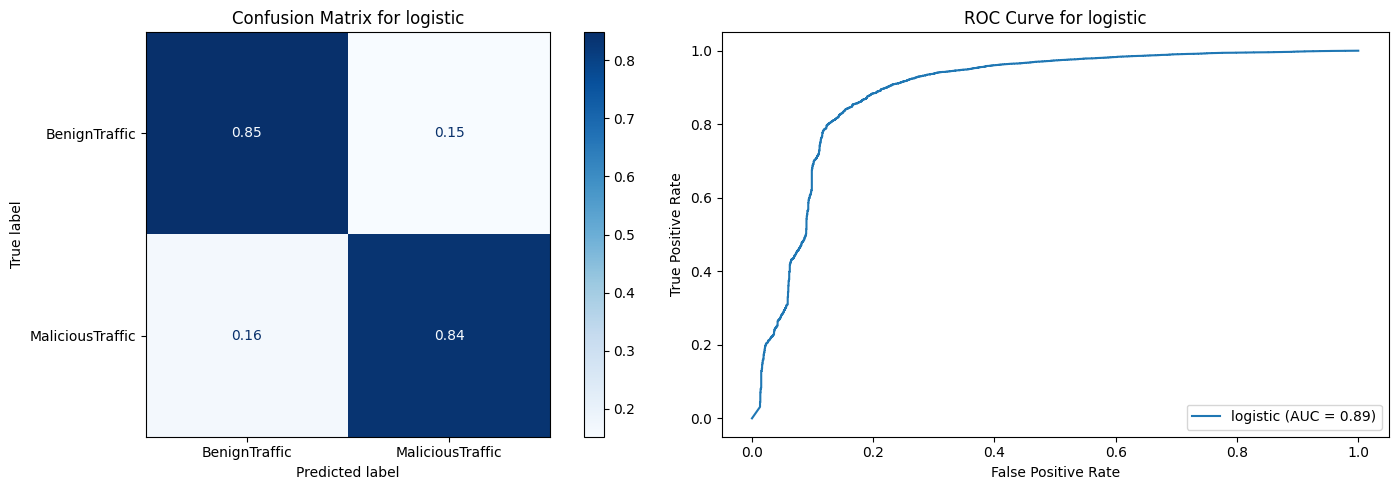

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.9 is maybe too old for this OS.
  warnings.warn(


Classification Report for knn:
              precision    recall  f1-score   support

           0       0.39      0.87      0.54      2036
           1       0.98      0.80      0.88     13964

    accuracy                           0.81     16000
   macro avg       0.68      0.83      0.71     16000
weighted avg       0.90      0.81      0.84     16000



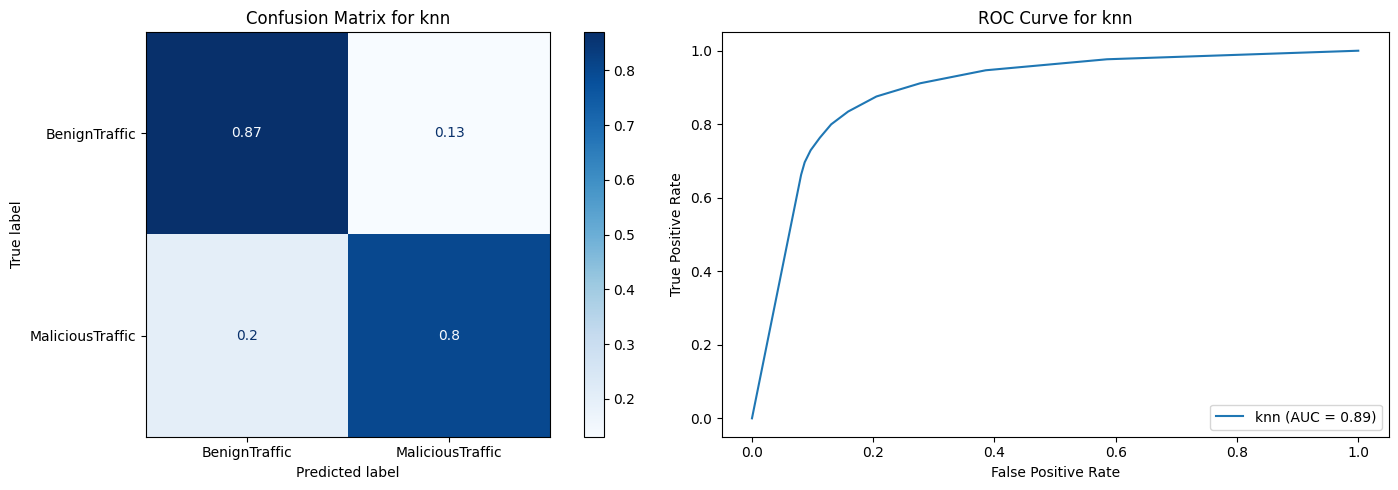

Classification Report for decision_tree:
              precision    recall  f1-score   support

           0       0.68      0.91      0.77      2036
           1       0.99      0.94      0.96     13964

    accuracy                           0.93     16000
   macro avg       0.83      0.92      0.87     16000
weighted avg       0.95      0.93      0.94     16000



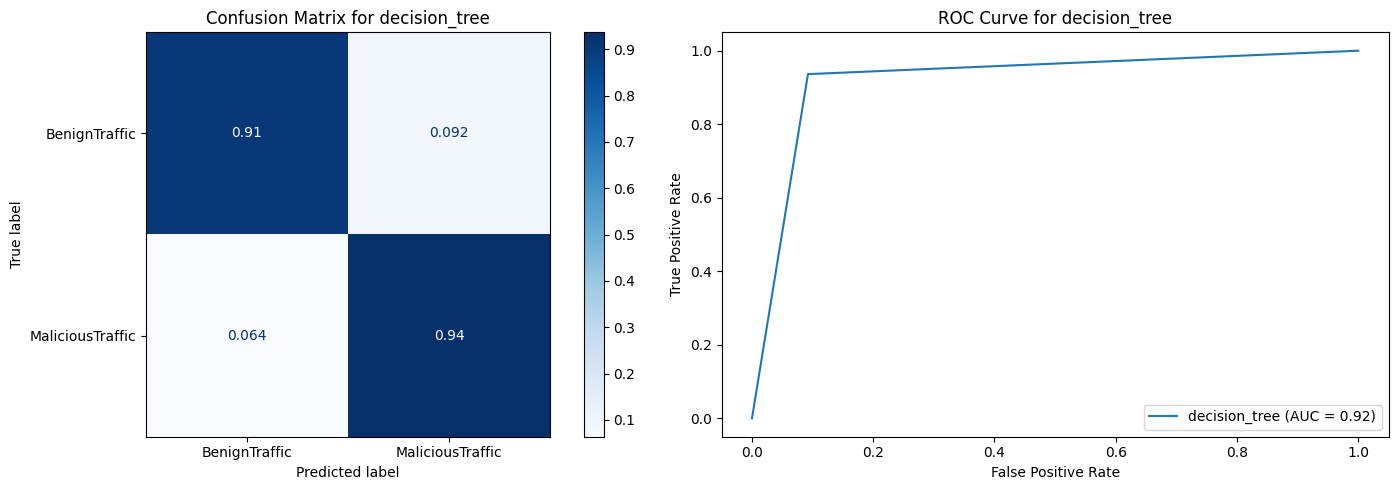

Classification Report for random_forest:
              precision    recall  f1-score   support

           0       0.73      0.90      0.81      2036
           1       0.99      0.95      0.97     13964

    accuracy                           0.95     16000
   macro avg       0.86      0.93      0.89     16000
weighted avg       0.95      0.95      0.95     16000



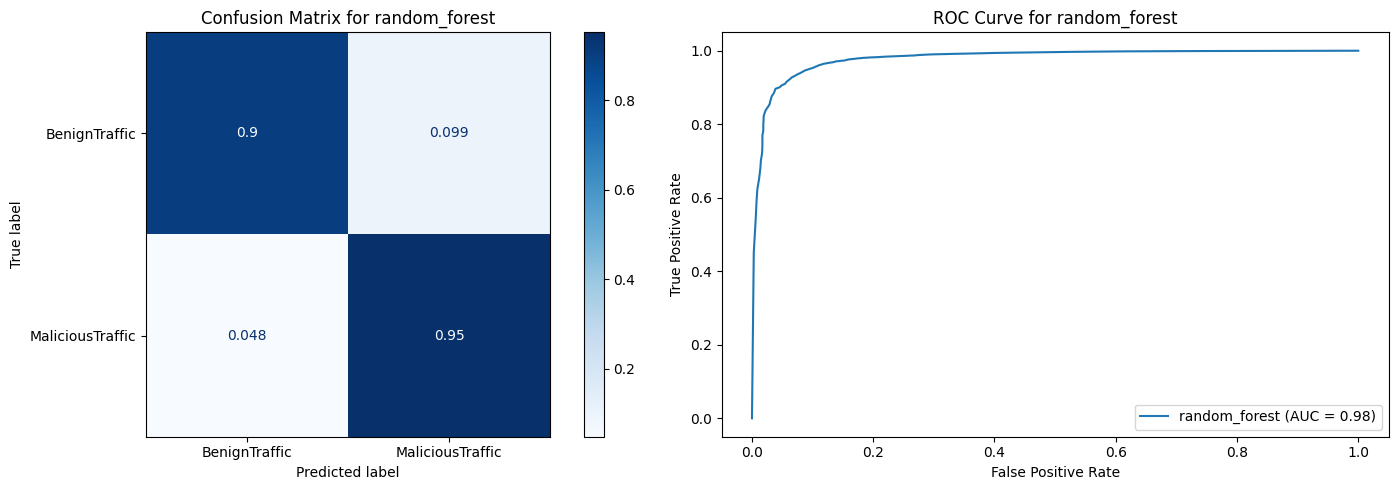

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification Report for mlp:
              precision    recall  f1-score   support

           0       0.54      0.84      0.66      2036
           1       0.98      0.90      0.93     13964

    accuracy                           0.89     16000
   macro avg       0.76      0.87      0.80     16000
weighted avg       0.92      0.89      0.90     16000



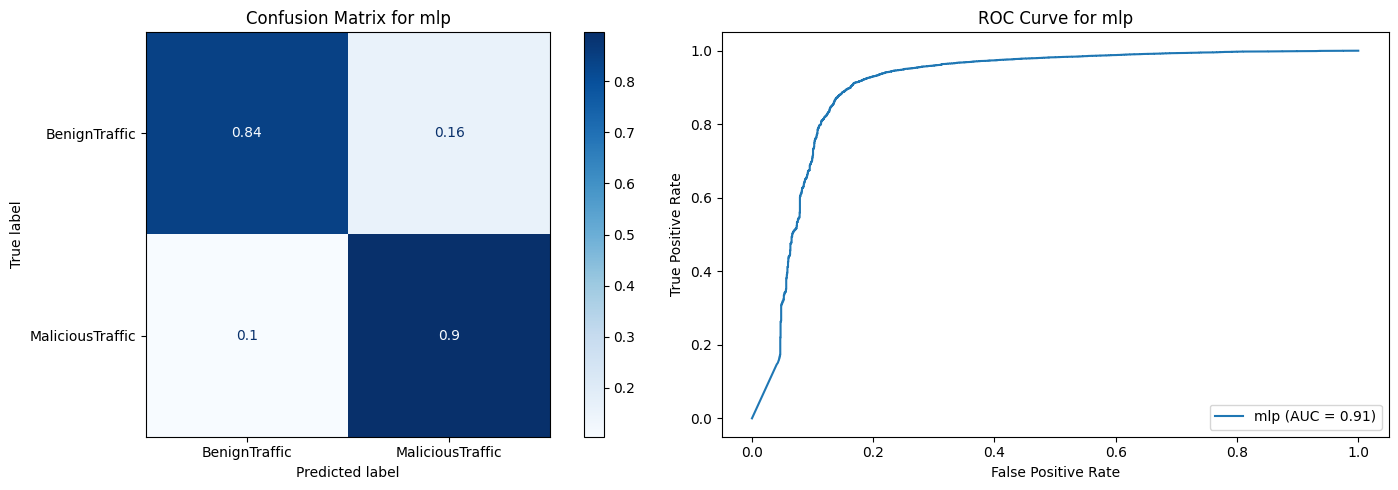

Classification Report for deeper_mlp:
              precision    recall  f1-score   support

           0       0.54      0.81      0.65      2036
           1       0.97      0.90      0.93     13964

    accuracy                           0.89     16000
   macro avg       0.75      0.85      0.79     16000
weighted avg       0.91      0.89      0.90     16000



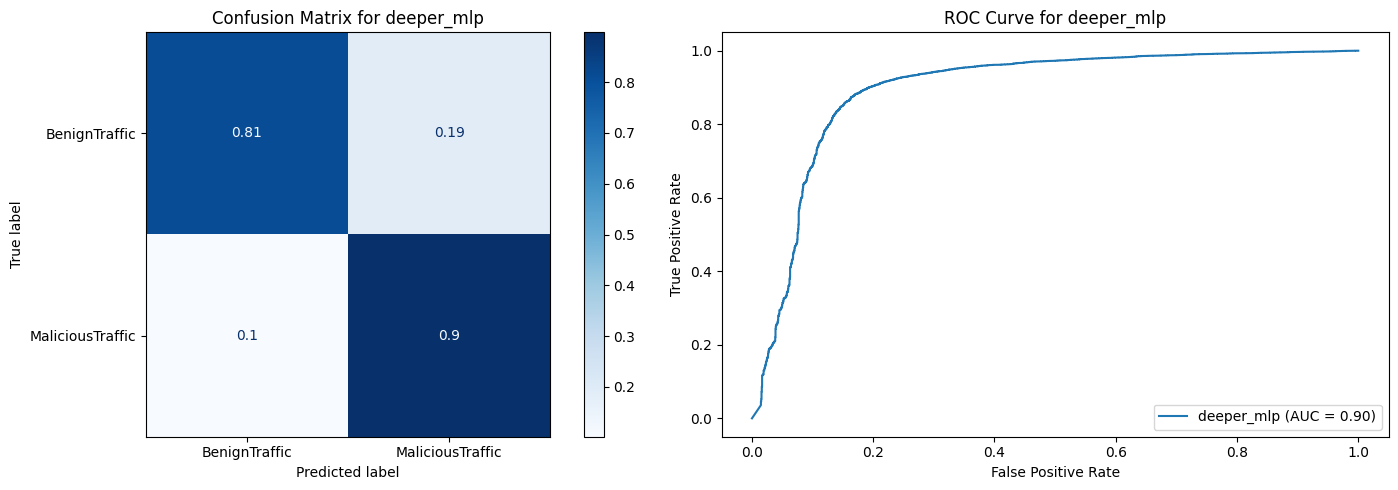

In [18]:
for i, (model_name, model) in enumerate(models.items()):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    model.fit(X_res, y_res)

    dump(model, f"models/binary/{model_name}.joblib")
    y_pred = model.predict(X_test)
    predictions[model_name] = y_pred

    # Classification Report
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    disp_cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, normalize='true'), display_labels=label2id)
    disp_cm.plot(cmap='Blues',ax=axes[0])
    axes[0].set_title(f"Confusion Matrix for {model_name}")

    # ROC Curve
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    disp_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name)
    disp_roc.plot(ax=axes[1])
    axes[1].set_title(f'ROC Curve for {model_name}')

    plt.tight_layout()
    plt.show()

Classification Report for logistic:
              precision    recall  f1-score   support

           0       0.47      0.85      0.61     10000
           1       0.97      0.85      0.91     63064

    accuracy                           0.85     73064
   macro avg       0.72      0.85      0.76     73064
weighted avg       0.90      0.85      0.87     73064



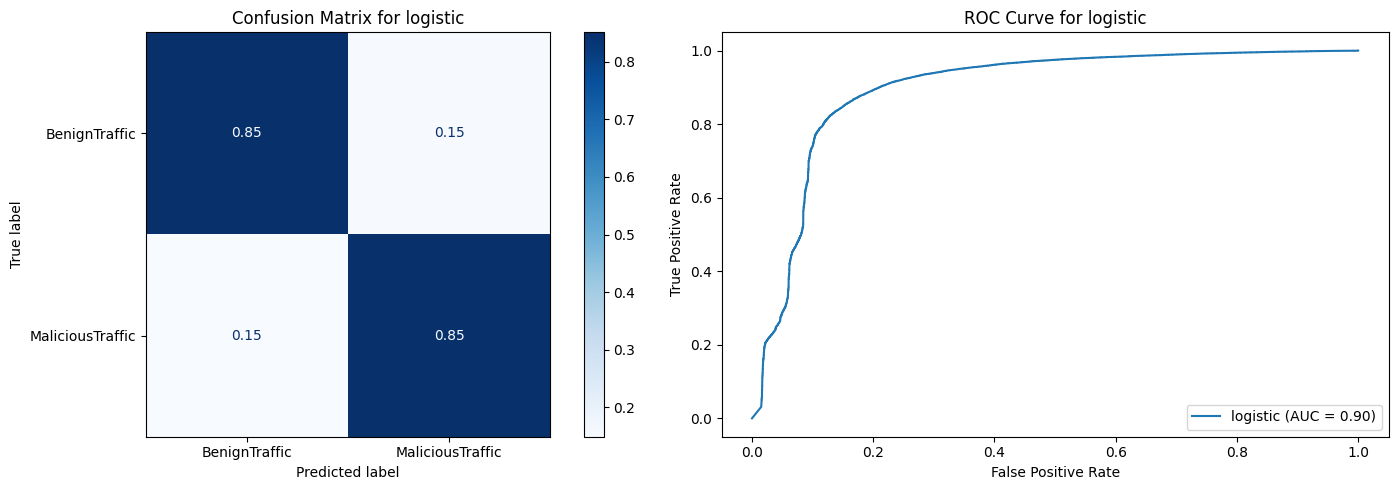

Classification Report for knn:
              precision    recall  f1-score   support

           0       0.43      0.87      0.58     10000
           1       0.98      0.82      0.89     63064

    accuracy                           0.82     73064
   macro avg       0.70      0.85      0.73     73064
weighted avg       0.90      0.82      0.85     73064



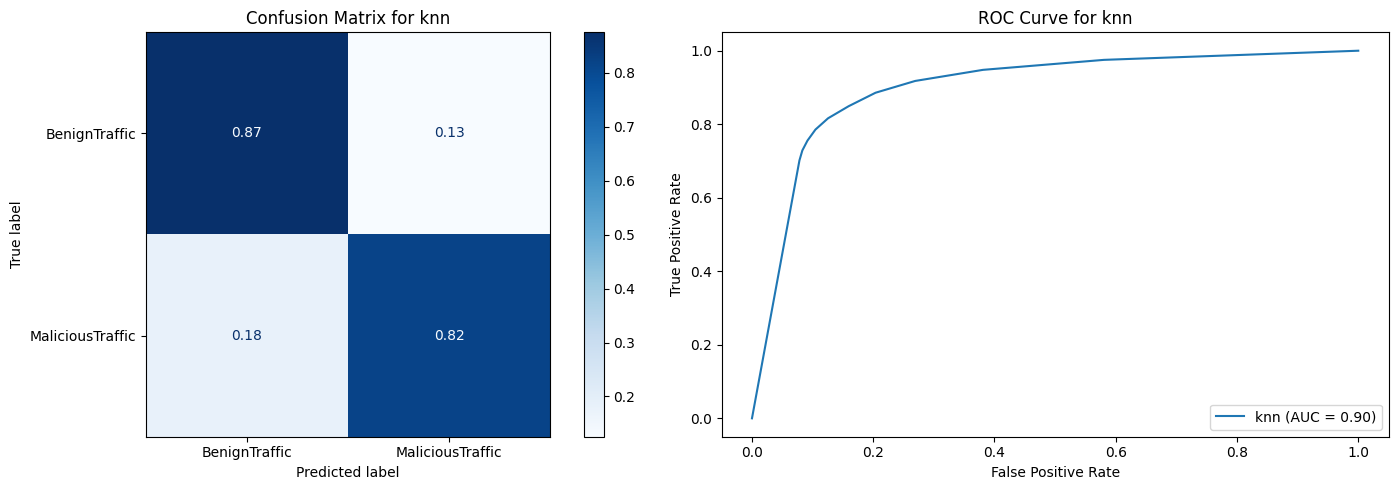

Classification Report for decision_tree:
              precision    recall  f1-score   support

           0       0.71      0.90      0.79     10000
           1       0.98      0.94      0.96     63064

    accuracy                           0.94     73064
   macro avg       0.85      0.92      0.88     73064
weighted avg       0.95      0.94      0.94     73064



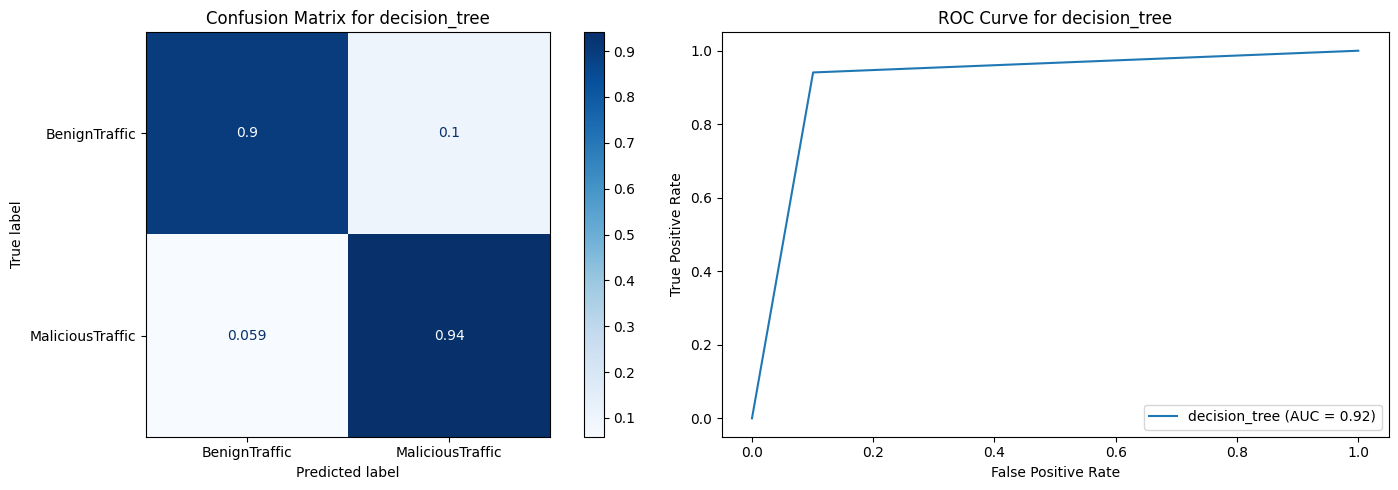

Classification Report for random_forest:
              precision    recall  f1-score   support

           0       0.77      0.90      0.83     10000
           1       0.98      0.96      0.97     63064

    accuracy                           0.95     73064
   macro avg       0.88      0.93      0.90     73064
weighted avg       0.96      0.95      0.95     73064



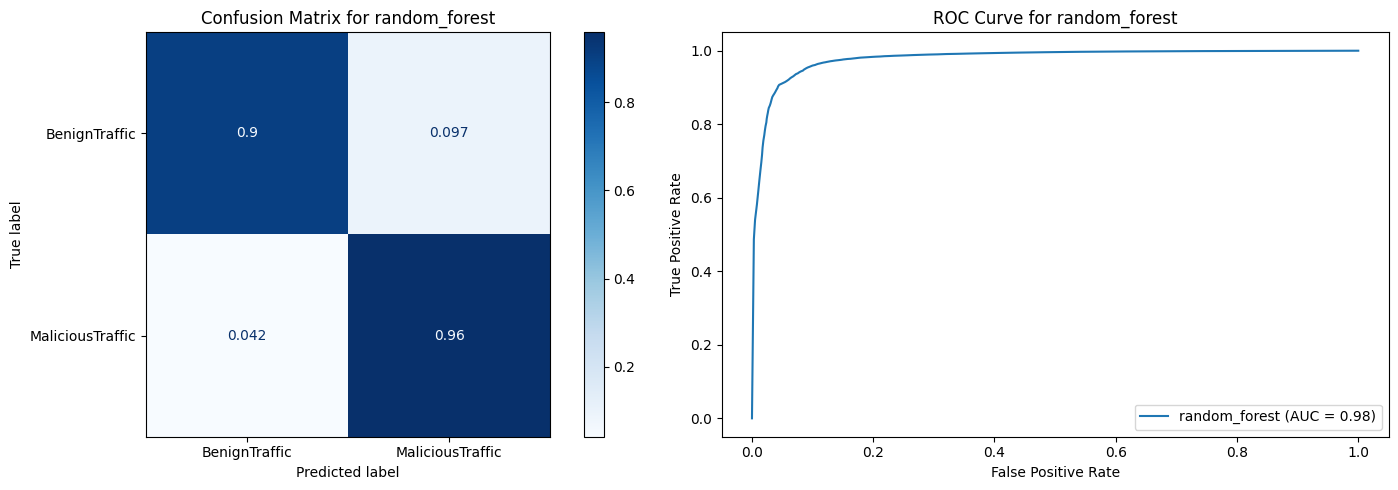

Classification Report for mlp:
              precision    recall  f1-score   support

           0       0.58      0.84      0.68     10000
           1       0.97      0.90      0.94     63064

    accuracy                           0.89     73064
   macro avg       0.77      0.87      0.81     73064
weighted avg       0.92      0.89      0.90     73064



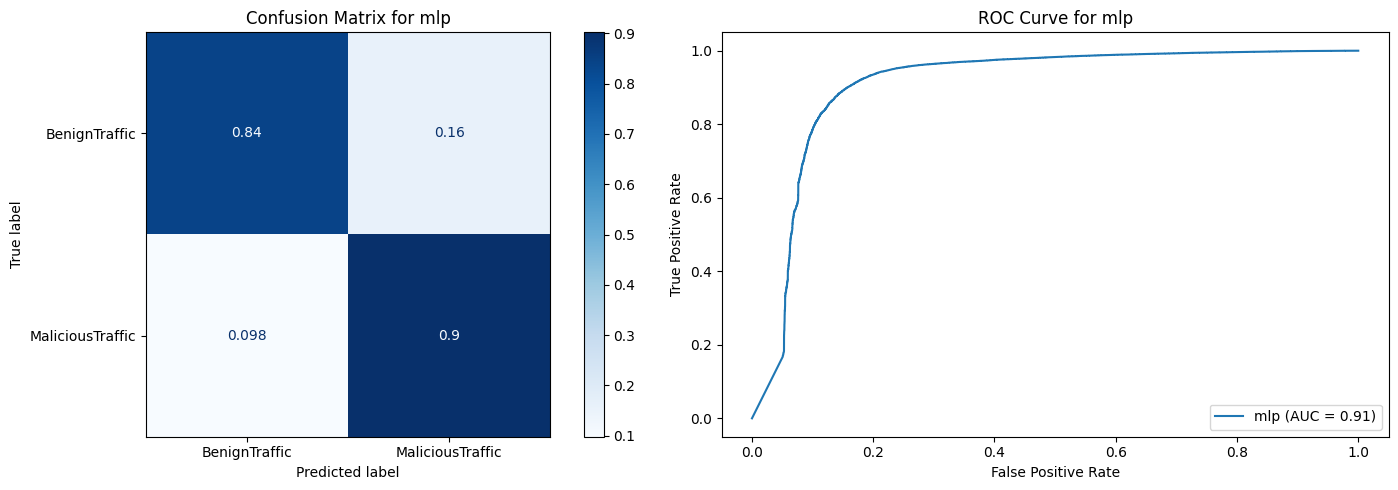

Classification Report for deeper_mlp:
              precision    recall  f1-score   support

           0       0.57      0.82      0.67     10000
           1       0.97      0.90      0.93     63064

    accuracy                           0.89     73064
   macro avg       0.77      0.86      0.80     73064
weighted avg       0.91      0.89      0.90     73064



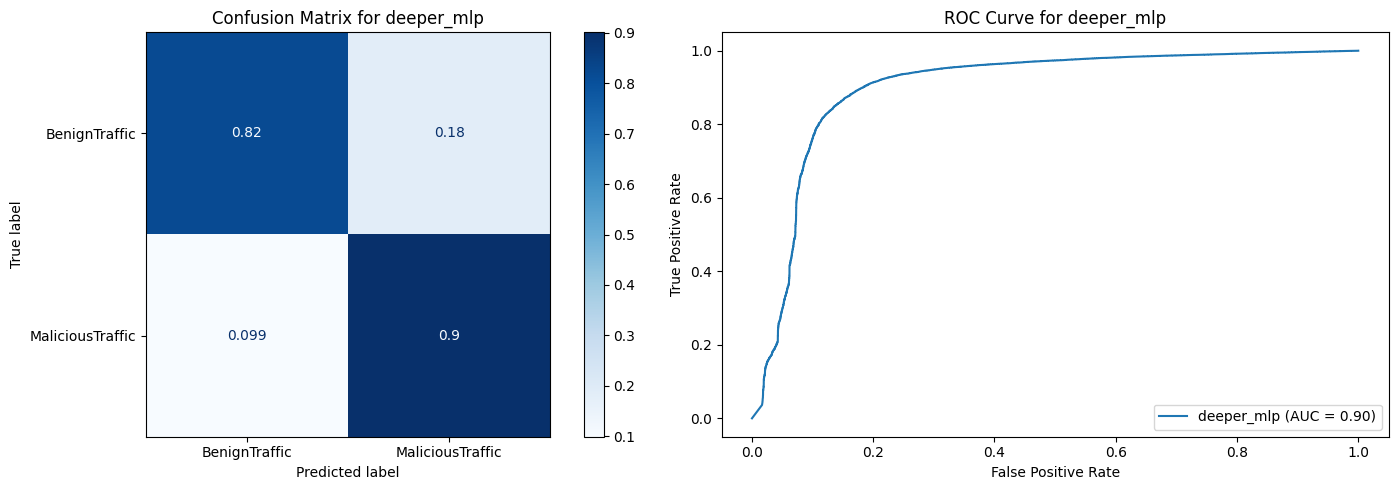

In [27]:
for i, (model_name, model) in enumerate(models.items()):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    model = load(f"models/binary/{model_name}.joblib")
    y_pred = model.predict(X_test_final)

    # Classification Report
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test_final, y_pred))

    # Confusion Matrix
    disp_cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_final, y_pred, normalize='true'), display_labels=label2id)
    disp_cm.plot(cmap='Blues',ax=axes[0])
    axes[0].set_title(f"Confusion Matrix for {model_name}")

    # ROC Curve
    y_prob = model.predict_proba(X_test_final)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test_final, y_prob)
    roc_auc = auc(fpr, tpr)

    disp_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name)
    disp_roc.plot(ax=axes[1])
    axes[1].set_title(f'ROC Curve for {model_name}')

    plt.tight_layout()
    plt.show()

We noticed that classifying malicious labels works better than classifying the benign ones - which could be better in the context of our data (better to detect malicious labels).
Above we see that decision trees and random forest perform better.

Remember that the y_final test is highly unbalanced, and we see that the binary classifiers, without too much of an analysis, perform quite well\
Remember that you tried to create a classifier with the unbalanced X_train, and it performed quite worse in the BenignTraffic (the one that is under represented)

## Let's try a voting classifier with all of our previously created ones (only one MLP)
We will look at hard voting and soft voting, one looks at the models and it selects one that has the majority of the classification. 
Soft voting on the other hand looks at the probabilities of each. 

In [31]:
models = {'logistic': LogisticRegression(random_state=42, max_iter=1000),
        'knn': KNeighborsClassifier(n_neighbors=10),
        'decision_tree': DecisionTreeClassifier(random_state=42),
        'random_forest': RandomForestClassifier(random_state=42),
        'mlp': MLPClassifier((10, 10, 5), random_state=42)}

clf_hard = VotingClassifier(estimators=[(name, model) for name, model in models.items()], voting='hard', verbose=True, n_jobs=-1)
clf_soft = VotingClassifier(estimators=[(name, model) for name, model in models.items()], voting='soft', verbose=True, n_jobs=-1)

In [32]:
clf_hard.fit(X_res, y_res)

[Voting] ...................... (2 of 5) Processing knn, total=   0.0s
[Voting] ................. (1 of 5) Processing logistic, total=   0.2s
[Voting] ............ (3 of 5) Processing decision_tree, total=   0.2s
[Voting] ............ (4 of 5) Processing random_forest, total=   2.9s
[Voting] ...................... (5 of 5) Processing mlp, total=   7.7s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


VotingClassifier(estimators=[('logistic',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)),
                             ('knn', KNeighborsClassifier(n_neighbors=10)),
                             ('decision_tree',
                              DecisionTreeClassifier(random_state=42)),
                             ('random_forest',
                              RandomForestClassifier(random_state=42)),
                             ('mlp',
                              MLPClassifier(hidden_layer_sizes=(10, 10, 5),
                                            random_state=42))],
                 n_jobs=-1, verbose=True)

In [33]:
dump(clf_hard, f"models/binary/voting_hard.joblib")

['models/binary/voting_hard.joblib']

Classification Report for Hard Voting:
              precision    recall  f1-score   support

           0       0.57      0.87      0.69      2036
           1       0.98      0.90      0.94     13964

    accuracy                           0.90     16000
   macro avg       0.77      0.89      0.81     16000
weighted avg       0.93      0.90      0.91     16000



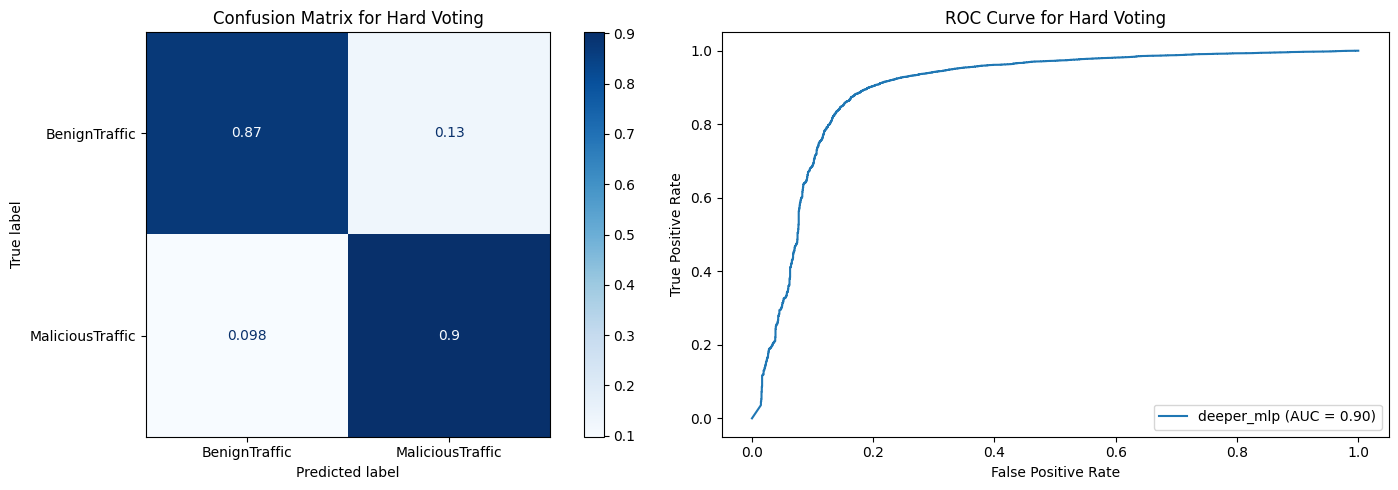

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

y_pred = clf_hard.predict(X_test)
predictions[model_name] = y_pred

# Classification Report
print(f"Classification Report for Hard Voting:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
disp_cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, normalize='true'), display_labels=label2id)
disp_cm.plot(cmap='Blues',ax=axes[0])
axes[0].set_title(f"Confusion Matrix for Hard Voting")

# ROC Curve
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

disp_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name)
disp_roc.plot(ax=axes[1])
axes[1].set_title(f'ROC Curve for Hard Voting')

plt.tight_layout()
plt.show()

Classification Report for Voting Hard:
              precision    recall  f1-score   support

           0       0.61      0.88      0.72     10000
           1       0.98      0.91      0.94     63064

    accuracy                           0.90     73064
   macro avg       0.79      0.89      0.83     73064
weighted avg       0.93      0.90      0.91     73064



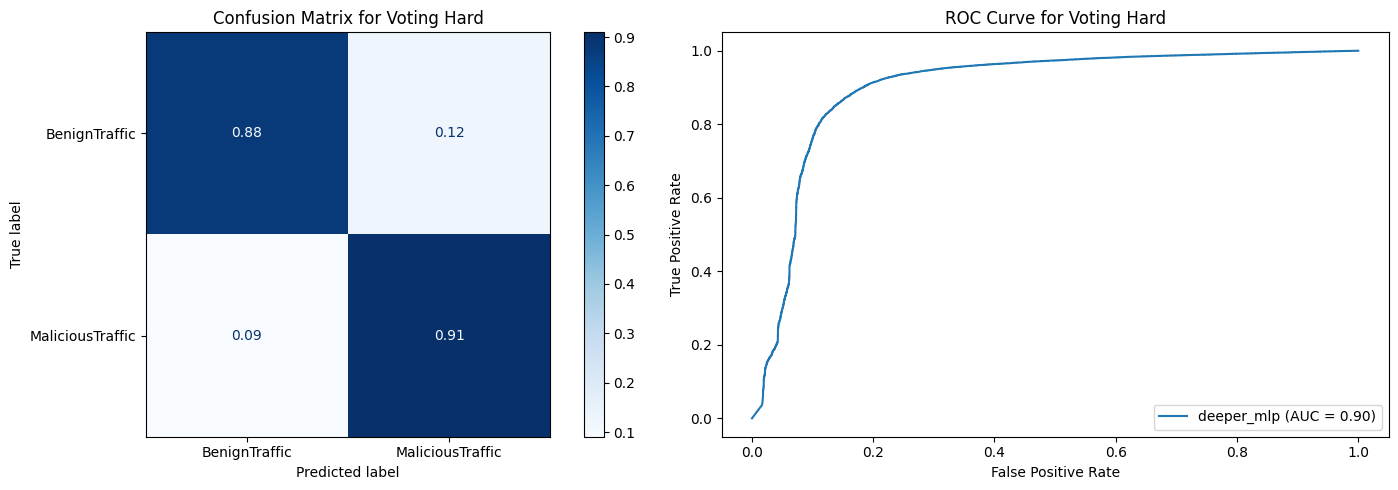

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

y_pred = clf_hard.predict(X_test_final)

# Classification Report
print(f"Classification Report for Voting Hard:")
print(classification_report(y_test_final, y_pred))

# Confusion Matrix
disp_cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_final, y_pred, normalize='true'), display_labels=label2id)
disp_cm.plot(cmap='Blues',ax=axes[0])
axes[0].set_title(f"Confusion Matrix for Voting Hard")

# ROC Curve
y_prob = model.predict_proba(X_test_final)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_final, y_prob)
roc_auc = auc(fpr, tpr)

disp_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name)
disp_roc.plot(ax=axes[1])
axes[1].set_title(f'ROC Curve for Voting Hard')

plt.tight_layout()
plt.show()

In [36]:
clf_soft.fit(X_res, y_res)

[Voting] ...................... (2 of 5) Processing knn, total=   0.0s
[Voting] ............ (3 of 5) Processing decision_tree, total=   0.3s
[Voting] ................. (1 of 5) Processing logistic, total=   0.2s
[Voting] ............ (4 of 5) Processing random_forest, total=   3.2s
[Voting] ...................... (5 of 5) Processing mlp, total=   7.6s


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


VotingClassifier(estimators=[('logistic',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)),
                             ('knn', KNeighborsClassifier(n_neighbors=10)),
                             ('decision_tree',
                              DecisionTreeClassifier(random_state=42)),
                             ('random_forest',
                              RandomForestClassifier(random_state=42)),
                             ('mlp',
                              MLPClassifier(hidden_layer_sizes=(10, 10, 5),
                                            random_state=42))],
                 n_jobs=-1, verbose=True, voting='soft')

In [37]:
dump(clf_hard, f"models/binary/voting_soft.joblib")

['models/binary/voting_soft.joblib']

Classification Report for Soft Voting:
              precision    recall  f1-score   support

           0       0.62      0.87      0.73      2036
           1       0.98      0.92      0.95     13964

    accuracy                           0.92     16000
   macro avg       0.80      0.90      0.84     16000
weighted avg       0.93      0.92      0.92     16000



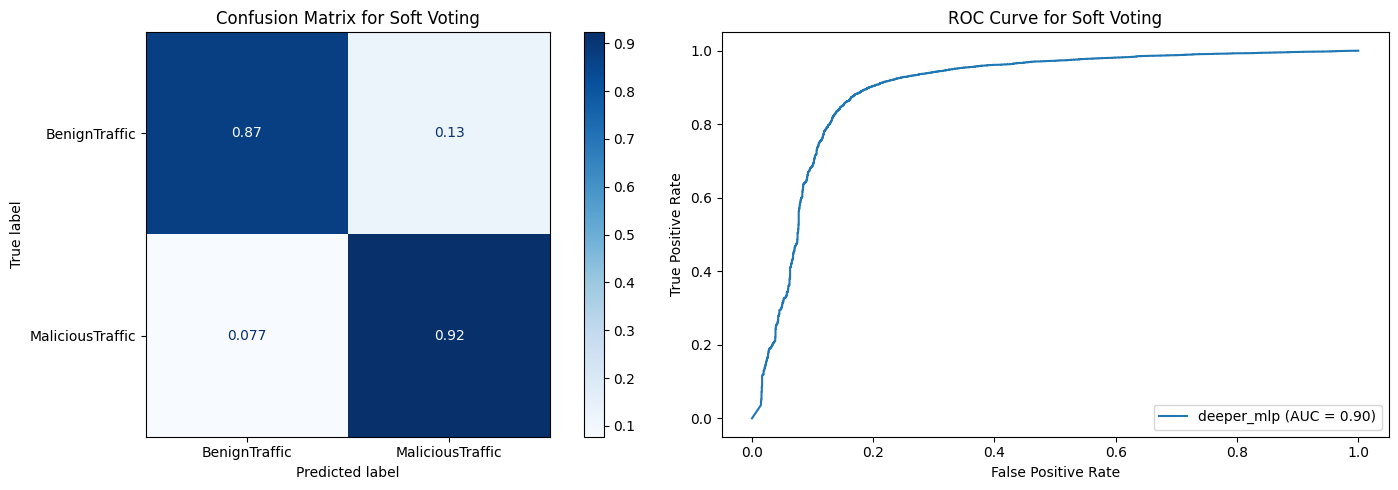

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

y_pred = clf_soft.predict(X_test)
predictions[model_name] = y_pred

# Classification Report
print(f"Classification Report for Soft Voting:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
disp_cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, normalize='true'), display_labels=label2id)
disp_cm.plot(cmap='Blues',ax=axes[0])
axes[0].set_title(f"Confusion Matrix for Soft Voting")

# ROC Curve
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

disp_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name)
disp_roc.plot(ax=axes[1])
axes[1].set_title(f'ROC Curve for Soft Voting')

plt.tight_layout()
plt.show()

Classification Report for Voting Soft:
              precision    recall  f1-score   support

           0       0.66      0.87      0.75     10000
           1       0.98      0.93      0.95     63064

    accuracy                           0.92     73064
   macro avg       0.82      0.90      0.85     73064
weighted avg       0.94      0.92      0.93     73064



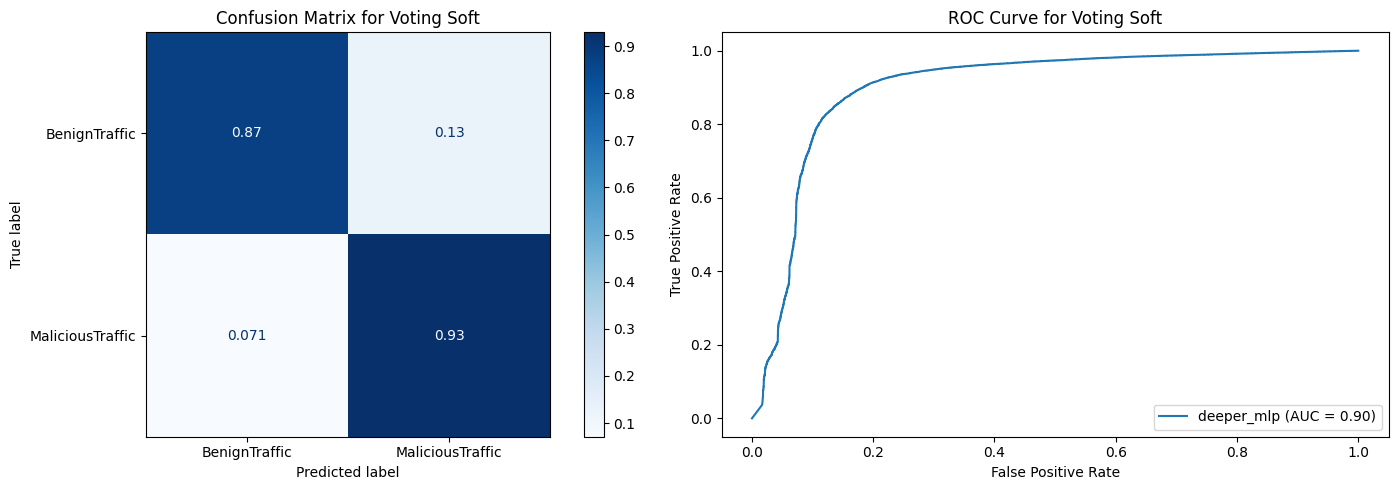

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

y_pred = clf_soft.predict(X_test_final)

# Classification Report
print(f"Classification Report for Voting Soft:")
print(classification_report(y_test_final, y_pred))

# Confusion Matrix
disp_cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_final, y_pred, normalize='true'), display_labels=label2id)
disp_cm.plot(cmap='Blues',ax=axes[0])
axes[0].set_title(f"Confusion Matrix for Voting Soft")

# ROC Curve
y_prob = model.predict_proba(X_test_final)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_final, y_prob)
roc_auc = auc(fpr, tpr)

disp_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name)
disp_roc.plot(ax=axes[1])
axes[1].set_title(f'ROC Curve for Voting Soft')

plt.tight_layout()
plt.show()

Both hard and soft voting work almost the same.

# Anomaly Detection Techniques

Let's try with some of the techniques within anomaly detection

We also tried resampling so that the malicious are much less than the benign.

After performing the analysis both wiht scaled and not scaled data, we saw that the acuracy was usually a little better with scaled data.

X_res, y_res
(40000, 46) (40000,)
-1    20000
 1    20000
dtype: int64


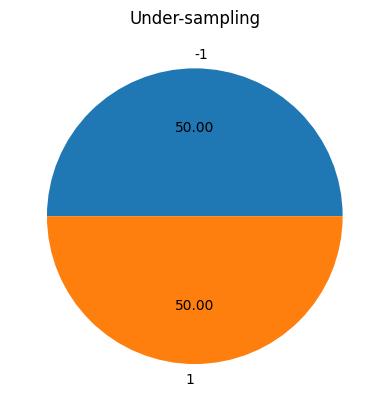

X_res_small, y_res_small
(25000, 46) (25000,)
 1    20000
-1     5000
dtype: int64


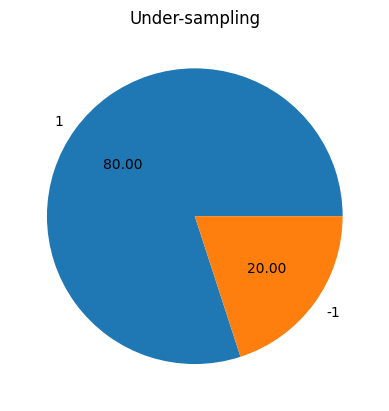

In [10]:
df = pd.read_csv('data/full_balanced_data.csv')

X = df.drop(['category_label', 'label'], axis=1).copy()
y = df['category_label'].copy()
standard_scaler = StandardScaler()

X = standard_scaler.fit_transform(X)

label2id = {'BenignTraffic': 1, 'Mirai': -1, 'DDoS': -1, 'Spoofing': -1, 'Web': -1, 'Recon': -1, 'BruteForce': -1, 'DoS': -1}
id2label = {1: 'BenignTraffic', -1: 'MaliciousTraffic'}

y = [label2id[label] for label in y]

rus = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X_res, y_res = rus.fit_resample(X, pd.Series( (v for v in y) ))
print('X_res, y_res')
print(X_res.shape, y_res.shape)
print(y_res.value_counts())

ax = y_res.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")
plt.show()

rus = RandomUnderSampler(sampling_strategy={-1: 5000})
X_res_small, y_res_small = rus.fit_resample(X, pd.Series( (v for v in y) ))
print('X_res_small, y_res_small')
print(X_res_small.shape, y_res_small.shape)
print(y_res_small.value_counts())

ax = y_res_small.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")
plt.show()

label2id = {'BenignTraffic': 1, 'MaliciousTraffic': -1}

In [11]:
outlier_fraction = 0.01

Fit the model on the cleaned data set

In [12]:
t_start = time.time()
y_pred = EllipticEnvelope(contamination=outlier_fraction).fit_predict(X)
t_stop = time.time()

print(f"Fitting time: {t_stop - t_start:.2f} s")
np.unique(y_pred, return_counts=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


Fitting time: 28.59 s


(array([-1,  1]), array([  1531, 151533]))

In [13]:
print('Accuracy on full dataset')
accuracy_score(y, y_pred)

Accuracy on full dataset


0.13052709977525742

The accuracy score is extremely low, as expected anomaly detection on the entire dataset does not work well. 

In [14]:
t_start = time.time()
y_pred = EllipticEnvelope(contamination=outlier_fraction).fit_predict(X_res)
t_stop = time.time()

print(f"Fitting time: {t_stop - t_start:.2f} s")
np.unique(y_pred, return_counts=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


Fitting time: 7.68 s


(array([-1,  1]), array([  400, 39600]))

Looking at the smaller dataset, our accuracy score slightly improves. This is because more of the benign values are captured, automatically leading to a higher accuracy score. 

In [15]:
print('Accuracy on smaller dataset')
accuracy_score(y_res, y_pred)

Accuracy on smaller dataset


0.5074

In [16]:
t_start = time.time()
y_pred = EllipticEnvelope(contamination=outlier_fraction).fit_predict(X_res_small)
t_stop = time.time()

print(f"Fitting time: {t_stop - t_start:.2f} s")
np.unique(y_pred, return_counts=True)

print('Accuracy on even smaller dataset')
accuracy_score(y_res_small, y_pred)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


Fitting time: 5.12 s
Accuracy on even smaller dataset


0.79456

Because the ellipticenvelope tries to find the normally distributed data, and point the outliers as anomalies, and in our dataset the majority of the data is "an anomaly" the methods don't work well.

In [17]:
t_start = time.time()
y_pred_svm = OneClassSVM(nu=outlier_fraction, kernel="rbf", gamma=0.1).fit(X).predict(X)
t_stop = time.time()

print(f"Fitting time: {t_stop - t_start:.2f} s")
print(np.unique(y_pred_svm, return_counts=True))
accuracy_score(y, y_pred_svm)

Fitting time: 215.15 s
(array([-1,  1]), array([  2233, 150831]))


0.14040532065018554

In [18]:
t_start = time.time()
y_pred_svm = OneClassSVM(nu=outlier_fraction, kernel="rbf", gamma=0.1).fit(X_res).predict(X_res)
t_stop = time.time()

print(f"Fitting time: {t_stop - t_start:.2f} s")
print(np.unique(y_pred_svm, return_counts=True))
accuracy_score(y_res, y_pred_svm)

Fitting time: 22.94 s
(array([-1,  1]), array([ 1385, 38615]))


0.513725

In [19]:
t_start = time.time()
y_pred_svm = OneClassSVM(nu=outlier_fraction, kernel="rbf", gamma=0.1).fit(X_res_small).predict(X_res_small)
t_stop = time.time()

print(f"Fitting time: {t_stop - t_start:.2f} s")
print(np.unique(y_pred_svm, return_counts=True))
accuracy_score(y_res_small, y_pred_svm)

Fitting time: 8.08 s
(array([-1,  1]), array([  696, 24304]))


0.79064

### Isolation forest

In [20]:
t_start = time.time()
y_pred_svm = IsolationForest(contamination=outlier_fraction, random_state=42).fit(X).predict(X) 
t_stop = time.time()

print(f"Fitting time: {t_stop - t_start:.2f} s")
print(np.unique(y_pred_svm, return_counts=True))
accuracy_score(y, y_pred_svm)

Fitting time: 1.71 s
(array([-1,  1]), array([  1531, 151533]))


0.13664218888830815

In [21]:
t_start = time.time()
y_pred_svm = IsolationForest(contamination=outlier_fraction, random_state=42).fit(X_res).predict(X_res) 
t_stop = time.time()

print(f"Fitting time: {t_stop - t_start:.2f} s")
print(np.unique(y_pred_svm, return_counts=True))
accuracy_score(y_res, y_pred_svm)

Fitting time: 0.78 s
(array([-1,  1]), array([  400, 39600]))


0.49765

In [22]:
t_start = time.time()
y_pred_svm = IsolationForest(contamination=outlier_fraction, random_state=42).fit(X_res_small).predict(X_res_small) 
t_stop = time.time()

print(f"Fitting time: {t_stop - t_start:.2f} s")
print(np.unique(y_pred_svm, return_counts=True))
accuracy_score(y_res_small, y_pred_svm)

Fitting time: 0.47 s
(array([-1,  1]), array([  250, 24750]))


0.79408

### Local outlier factor

In [23]:
t_start = time.time()
y_pred_svm = LocalOutlierFactor(n_neighbors=35, contamination=outlier_fraction).fit_predict(X)
t_stop = time.time()

print(f"Fitting time: {t_stop - t_start:.2f} s")
print(np.unique(y_pred_svm, return_counts=True))
accuracy_score(y, y_pred_svm)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.9 is maybe too old for this OS.
  warnings.warn(


Fitting time: 55.56 s
(array([-1,  1]), array([  1531, 151533]))


0.14053598494747296

In [24]:
t_start = time.time()
y_pred_svm = LocalOutlierFactor(n_neighbors=35, contamination=outlier_fraction).fit_predict(X_res)
t_stop = time.time()

print(f"Fitting time: {t_stop - t_start:.2f} s")
print(np.unique(y_pred_svm, return_counts=True))
accuracy_score(y_res, y_pred_svm)

Fitting time: 4.89 s
(array([-1,  1]), array([  400, 39600]))


0.51

In [25]:
t_start = time.time()
y_pred_svm = LocalOutlierFactor(n_neighbors=35, contamination=outlier_fraction).fit_predict(X_res_small)
t_stop = time.time()

print(f"Fitting time: {t_stop - t_start:.2f} s")
print(np.unique(y_pred_svm, return_counts=True))
accuracy_score(y_res_small, y_pred_svm)

Fitting time: 2.00 s
(array([-1,  1]), array([  250, 24750]))


0.81